# Particle Flow Network to Handle Single Track Single Cluster Dataset

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUS - import TensorFlow

In [24]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2021-07-25 20:03:38.802488: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-25 20:03:38.807041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-25 20:03:38.823902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-25 20:03:38.824064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-25 20:03:38.824115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-25 20:03:38.824162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

['/device:GPU:0']

nd.so.10
2021-07-25 20:03:38.824253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2021-07-25 20:03:38.824296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.11
2021-07-25 20:03:38.824335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-07-25 20:03:38.828728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1888] Adding visible gpu devices: 0
2021-07-25 20:03:38.828875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1287] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-25 20:03:38.828895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1293]      0 
2021-07-25 20:03:38.828912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1306] 0:   N 
2021-07-25 20:03:38.833677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Created TensorFlow dev

## Import EnergyFlow

In [25]:
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
print('Energy Flow Version: '+str(ef.__version__))

Energy Flow Version: 1.3.2


# Particle Truth Energy Target

### Load Data
#### X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]
#### Y = [truthPartE, truthTrackPt, cluster_ENG_CALIB_TOT]

In [36]:
t0 = t.time()
Xraw = np.load('/data/rbate/X_STSC_502_files.npy', mmap_mode='r')[:500000,:,:]
Yraw = np.load('/data/rbate/Y_STSC_502_files.npy', mmap_mode='r')[:500000,:]

X = np.lib.format.open_memmap('/data/rbate/X_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/rbate/Y_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)

t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

Time to load memory mapped data: 110.88875913619995 (s)


In [37]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Number targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Number targets below 50 GeV: 0
Number of events: 500000


## Show Targets

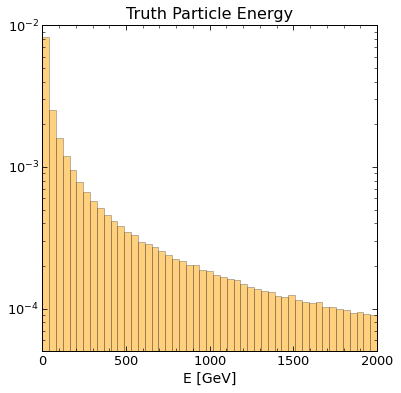

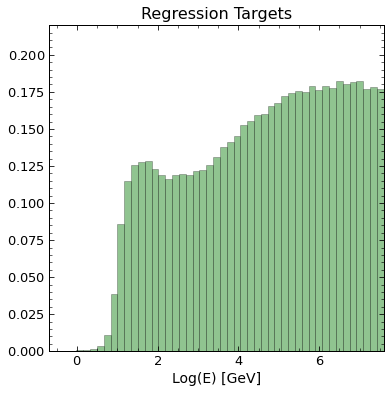

In [38]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,0][target_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_raw_2021-07-15.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_log_2021-07-08.png', format='png')
plt.show()

## Deep Set Normalization

In [39]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 106.21567916870117 (s)


## Show Inputs

<Figure size 799.992x599.976 with 0 Axes>

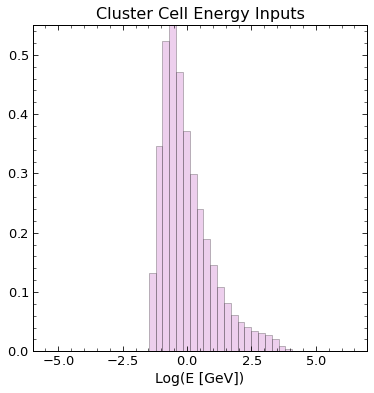

<Figure size 799.992x599.976 with 0 Axes>

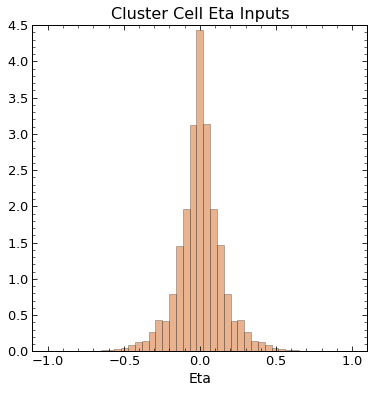

<Figure size 799.992x599.976 with 0 Axes>

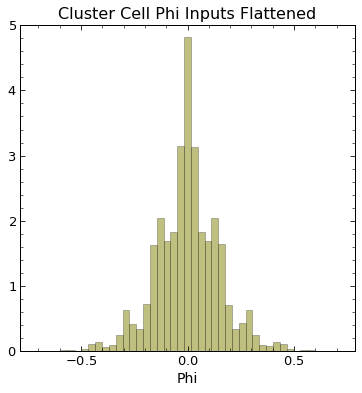

<Figure size 799.992x599.976 with 0 Axes>

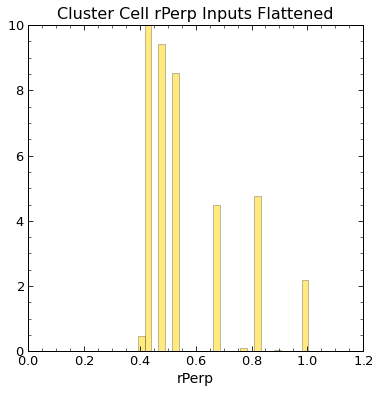

In [40]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_Einputs_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_EtaInputs_2021-07-08.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_PhiInputs_2021-07-08.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_rPerpInputs_2021-07-08.png', format='png')
plt.show()

### Model Settings

In [41]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 3000

train -- val -- test
350000 -- 75000 -- 75000


#### Train/Val/Test Split

In [42]:
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(350000, 1001, 5)
(350000,)


### Build Particle Flow Network

In [43]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

## Train Model

In [22]:
t0 = t.time()
history = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2021-07-24 18:31:21.175531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-24 18:31:21.195671: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/1500


2021-07-24 18:31:21.727798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-24 18:31:22.666690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


24/24 [==============================] - 6s 203ms/step - loss: 1951.0970 - val_loss: 68.5384
Epoch 2/1500
24/24 [==============================] - 4s 166ms/step - loss: 33.2510 - val_loss: 6.2522
Epoch 3/1500
24/24 [==============================] - 4s 165ms/step - loss: 4.4700 - val_loss: 1.8930
Epoch 4/1500
24/24 [==============================] - 4s 166ms/step - loss: 1.6136 - val_loss: 1.0853
Epoch 5/1500
24/24 [==============================] - 4s 165ms/step - loss: 0.9705 - val_loss: 0.7646
Epoch 6/1500
24/24 [==============================] - 4s 167ms/step - loss: 0.7479 - val_loss: 0.6306
Epoch 7/1500
24/24 [==============================] - 4s 170ms/step - loss: 0.6163 - val_loss: 0.5982
Epoch 8/1500
24/24 [==============================] - 5s 209ms/step - loss: 0.5595 - val_loss: 0.5495
Epoch 9/1500
24/24 [==============================] - 5s 213ms/step - loss: 0.4953 - val_loss: 0.5427
Epoch 10/1500
24/24 [==============================] - 5s 206ms/step - loss: 0.4770 - val_

### Predictions

#### Histogram of Predictions

In [ ]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-4,8,30, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-5,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()